<a href="https://colab.research.google.com/github/Bapiggott/CSI4140-DNN-FromScratch/blob/main/Brett_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Hyperparameters
input_size = 32 * 32 * 3  # CIFAR-10 images are 32x32 with 3 channels
hidden_size = 256
num_classes = 10
learning_rate = 0.01
num_epochs = 10
batch_size = 64

In [ ]:
def get_data_loaders():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.CIFAR10(
        root='./data', train=True, transform=transform, download=True
    )
    test_dataset = datasets.CIFAR10(
        root='./data', train=False, transform=transform, download=True
    )
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, batch_size=batch_size, shuffle=False
    )
    return train_loader, test_loader

In [ ]:
class FullyConnectedNN:
    def __init__(self, input_size, hidden_size, num_classes):
        # Manually initializing weights and biases
        self.fc1_weight = torch.randn(hidden_size, input_size) * 0.01
        self.fc1_bias   = torch.zeros(hidden_size)
        self.fc2_weight = torch.randn(num_classes, hidden_size) * 0.01
        self.fc2_bias   = torch.zeros(num_classes)

    def relu(self, x):
        return (x > 0).float() * x  # Elementwise ReLU

In [ ]:
############################################
#           Training Function              #
############################################
def train_model(model, train_loader, device, lr=1e-3):
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Move data to the device
        images, labels = images.to(device), labels.to(device)
        B = images.size(0)  # batch size

        ################################################
        # 1) Forward Pass (Manual)
        ################################################
        # Flatten input => shape: (B, 3072)
        x = images.view(B, -1)

        # First linear layer
        z1 = x @ model.fc1_weight.T + model.fc1_bias  # (B, hidden_size)
        # ReLU
        a1 = model.relu(z1)                           # (B, hidden_size)

        # Second linear layer => logits
        logits = a1 @ model.fc2_weight.T + model.fc2_bias  # (B, num_classes)

        ################################################
        # 2) Softmax + Cross-Entropy (Manual)
        ################################################
        # Softmax
        p = torch.exp(logits)
        p = p / p.sum(dim=1, keepdim=True)  # shape: (B, num_classes)

        # One-hot for ground-truth
        one_hot = torch.zeros_like(p)  # shape: (B, num_classes)
        one_hot[range(B), labels] = 1.0

        # Cross-entropy loss (mean over batch)
        loss_vector = - (one_hot * p.log()).sum(dim=1)  # shape: (B,)
        loss = loss_vector.mean()                       # scalar

        train_loss += loss.item()

        ################################################
        # 3) Zero out Gradients (no autograd)
        ################################################
        # Because we're doing manual grad, we ensure no stale grads.
        # We'll compute them all in local variables below, so we skip storing in .grad.
        # Just be sure we do param updates from local grads.

        ################################################
        # 4) Compute Gradients Manually
        ################################################
        # dLoss/dlogits => (B, C)
        dlogits = (p - one_hot) / B

        # dW2 => (C, H)
        dW2 = dlogits.T @ a1
        # db2 => (C,)
        db2 = dlogits.sum(dim=0)

        # da1 => (B, H)
        da1 = dlogits @ model.fc2_weight

        # dz1 (account for ReLU)
        dz1 = da1 * (z1 > 0).float()

        # dW1 => (H, D)
        dW1 = dz1.T @ x
        # db1 => (H,)
        db1 = dz1.sum(dim=0)

        ################################################
        # 5) Gradient Descent Step
        ################################################
        # W1 = W1 - lr * dW1
        model.fc1_weight -= lr * dW1
        model.fc1_bias   -= lr * db1
        model.fc2_weight -= lr * dW2
        model.fc2_bias   -= lr * db2

        ################################################
        # 6) Accuracy for This Batch
        ################################################
        # predictions from logits (no softmax needed)
        _, predicted = logits.max(dim=1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Return average loss + accuracy
    avg_loss = train_loss / (total // batch_size)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

In [ ]:
############################################
#         Evaluation Function              #
############################################
def evaluate_model(model, test_loader, device):
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            B = images.size(0)

            # Forward pass
            x = images.view(B, -1)
            z1 = x @ model.fc1_weight.T + model.fc1_bias
            a1 = model.relu(z1)
            logits = a1 @ model.fc2_weight.T + model.fc2_bias

            # Softmax
            p = torch.exp(logits)
            p = p / p.sum(dim=1, keepdim=True)

            # One-hot
            one_hot = torch.zeros_like(p)
            one_hot[range(B), labels] = 1.0

            # Cross-Entropy
            loss_vector = - (one_hot * p.log()).sum(dim=1)
            loss = loss_vector.mean()
            test_loss += loss.item()

            # Accuracy
            _, predicted = logits.max(dim=1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = test_loss / (total // batch_size)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

In [ ]:
############################################
#               Main Script                #
############################################
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loader, test_loader = get_data_loaders()

    # Initialize model & move weights to device
    model = FullyConnectedNN(input_size, hidden_size, num_classes)
    model.fc1_weight = model.fc1_weight.to(device)
    model.fc1_bias = model.fc1_bias.to(device)
    model.fc2_weight = model.fc2_weight.to(device)
    model.fc2_bias = model.fc2_bias.to(device)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(model, train_loader, device, lr=learning_rate)
        test_loss, test_acc = evaluate_model(model, test_loader, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(
          f"Epoch [{epoch+1}/{num_epochs}]\n"
          f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%\n"
          f"  Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.2f}%\n"
)

Epoch [1/10]
  Train Loss: 2.0135, Train Acc: 29.11%
  Test  Loss: 1.8373, Test  Acc: 34.89%

Epoch [2/10]
  Train Loss: 1.7562, Train Acc: 38.26%
  Test  Loss: 1.6960, Test  Acc: 40.27%

Epoch [3/10]
  Train Loss: 1.6525, Train Acc: 41.93%
  Test  Loss: 1.6226, Test  Acc: 43.64%

Epoch [4/10]
  Train Loss: 1.5871, Train Acc: 44.34%
  Test  Loss: 1.5735, Test  Acc: 45.37%

Epoch [5/10]
  Train Loss: 1.5387, Train Acc: 46.23%
  Test  Loss: 1.5349, Test  Acc: 46.48%

Epoch [6/10]
  Train Loss: 1.4972, Train Acc: 47.82%
  Test  Loss: 1.5047, Test  Acc: 47.72%

Epoch [7/10]
  Train Loss: 1.4605, Train Acc: 49.33%
  Test  Loss: 1.4782, Test  Acc: 48.79%

Epoch [8/10]
  Train Loss: 1.4279, Train Acc: 50.24%
  Test  Loss: 1.4617, Test  Acc: 49.40%

Epoch [9/10]
  Train Loss: 1.3972, Train Acc: 51.63%
  Test  Loss: 1.4416, Test  Acc: 49.59%

Epoch [10/10]
  Train Loss: 1.3690, Train Acc: 52.56%
  Test  Loss: 1.4283, Test  Acc: 50.60%



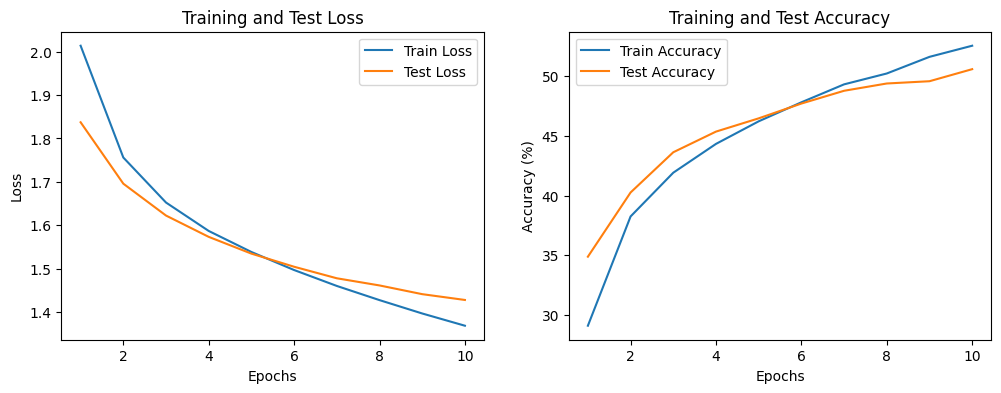

In [ ]:
# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Test Accuracy')

plt.show()
